In [1]:
import numpy as np
import matplotlib.pyplot as plt

def structure_element(radius,types):
    #type: 0-line,1-circle,2-triangle
    se = np.zeros(radius*2+1)
    if types == 0:
        se = se + radius
    if types == 1:
        for i in range(radius*2+1):
            se[i]= np.sqrt(radius*radius-(radius-i)*(radius-i))
    if types == 2:
        for i in range(radius+1):
            se[i] = i
            se[radius*2-i] = i
    return se

se1 = structure_element(3,0)
se2 = structure_element(5,0)
se3 = structure_element(9,0)
plt.figure(figsize=(8,4))
plt.title("line structure elements")
plt.plot(se1)
plt.plot(se2)
plt.plot(se3)
plt.show()

se1 = structure_element(3,1)
se2 = structure_element(5,1)
se3 = structure_element(9,1)
plt.figure(figsize=(8,4))
plt.title("circle structure elements")
plt.plot(se1)
plt.plot(se2)
plt.plot(se3)
plt.show()

se1 = structure_element(3,2)
se2 = structure_element(5,2)
se3 = structure_element(9,2)
plt.figure(figsize=(8,4))
plt.title("triangle structure elements")
plt.plot(se1)
plt.plot(se2)
plt.plot(se3)
plt.show()

<Figure size 800x400 with 1 Axes>

<Figure size 800x400 with 1 Axes>

<Figure size 800x400 with 1 Axes>

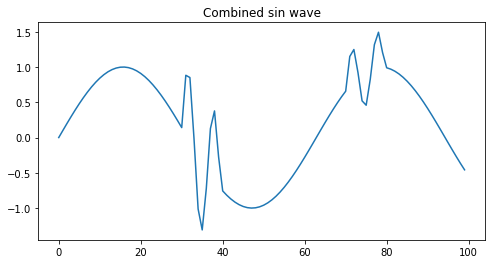

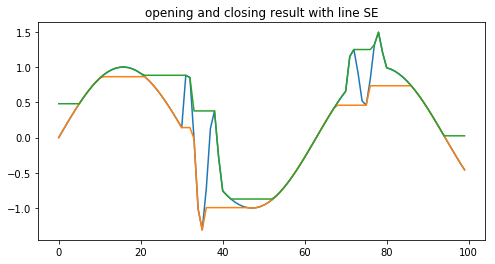

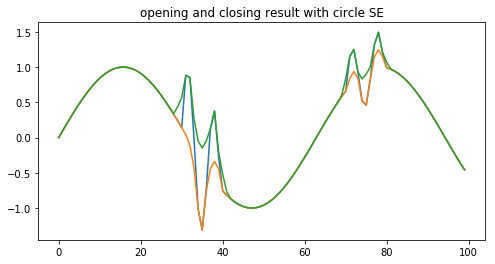

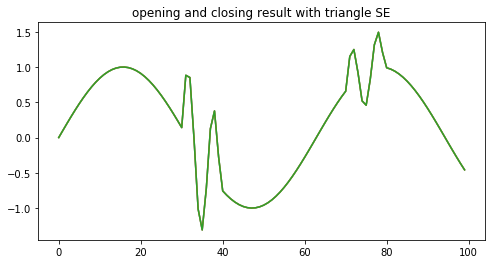

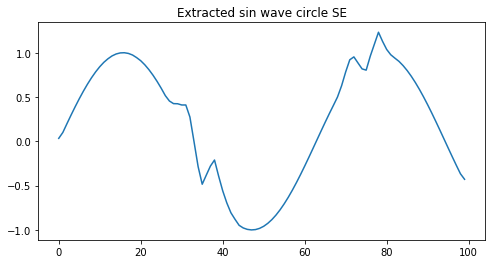

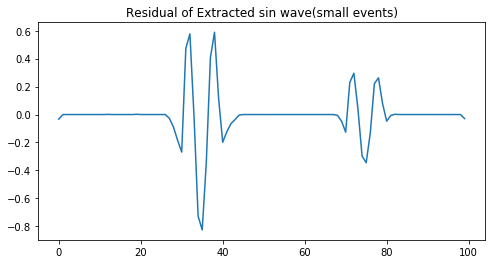

In [2]:
time        = np.arange(0, 10, 0.1);
data   = np.sin(time)
data_add = np.sin(np.arange(0,10))
data[30:40] = data[30:40] + data_add
data[70:80] = data[70:80] + data_add*0.5
r = 5
plt.figure(figsize=(8,4))
plt.title("Combined sin wave")
plt.plot(data)
plt.show()

def erosion(data,se):
    r = (len(se)-1)/2
    l = len(se)
    data = np.insert(data,0,data[0].repeat(r),0)
    data = np.append(data,data[-1].repeat(r))
    result = np.zeros(len(data)-len(se)+1)
    for i in range(len(data)-len(se)+1):
        result[i] = min(data[i:i+len(se)]-se)
    return result

def dilation(data,se):
    r = (len(se)-1)/2
    l = len(se)
    data = np.insert(data,0,data[0].repeat(r),0)
    data = np.append(data,data[-1].repeat(r))
    result = np.zeros(len(data)-len(se)+1)
    for i in range(len(data)-len(se)+1):
        result[i] = max(data[i:i+len(se)]+se)
    return result

def opening(data,se):
    data = erosion(data,se)
    data = dilation(data,se)
    return data

def closing(data,se):
    data = dilation(data,se)
    data = erosion(data,se)
    return data

se = structure_element(5,0)
data1 = opening(data,se)
data2 = closing(data,se)

plt.figure(figsize=(8,4))
plt.title("opening and closing result with line SE")
plt.plot(data)
plt.plot(data1)
plt.plot(data2)
plt.show()

se = structure_element(5,1)
data1 = opening(data,se)
data2 = closing(data,se)

plt.figure(figsize=(8,4))
plt.title("opening and closing result with circle SE")
plt.plot(data)
plt.plot(data1)
plt.plot(data2)
plt.show()

se = structure_element(5,2)
data1 = opening(data,se)
data2 = closing(data,se)

plt.figure(figsize=(8,4))
plt.title("opening and closing result with triangle SE")
plt.plot(data)
plt.plot(data1)
plt.plot(data2)
plt.show()

se = structure_element(15,1)
data1 = opening(data,se)
data2 = closing(data,se)
sin_extract = (data1+data2)/2
residual = data - sin_extract

plt.figure(figsize=(8,4))
plt.title("Extracted sin wave circle SE")
plt.plot(sin_extract)
plt.show()

plt.figure(figsize=(8,4))
plt.title("Residual of Extracted sin wave(small events)")
plt.plot(residual)
plt.show()

In [70]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pywt
from influxdb import InfluxDBClient
import operator
import scipy.signal as sg
import scipy as sp
import time as tm
import datetime as dt

from numpy.fft import rfft, irfft, rfftfreq
from scipy import fftpack
import pandas as pd
import pickle as pk

### without normalization

In [113]:
def aggrenvelope(start_time,end_time,filenames,personname,trajectory):
    '''
    example:
    start_time = '16:39:20'
    end_time = '16:39:50'
    filename = 'a673_corner.csv'
    '''
    
    print('#'*115)
    print('{}, {}, {}, {}'.format(start_time,end_time,personname,trajectory))
    
    start_timestamp = tm.mktime(dt.datetime.strptime(start_time, "%H:%M:%S").timetuple())
    end_timestamp = tm.mktime(dt.datetime.strptime(end_time, "%H:%M:%S").timetuple())
    
    envelope_results = []
    labels = []
    
    for filename in filenames:
        #print('#'*115)
        with open(filename, newline='') as csvfile:
            spamreader = csv.reader(csvfile)
            seis = []
            first = True
            for row in spamreader:
                if first:
                    first = False
                    continue
                row = row[0].split(';')
                curr_time = row[1].strip('"').split('T')[1].split('-')[0]
                curr_timestamp = tm.mktime(dt.datetime.strptime(curr_time, "%H:%M:%S").timetuple())
                if curr_timestamp >= start_timestamp and curr_timestamp <= end_timestamp:
                    seis.append(row[2])
            seis = np.array(seis)
            seis = seis.astype(np.float)
            #print(seis)
            
        if len(seis) == 0:
            continue
        data = seis[:]
        data = data-np.mean(data)
        #print(data)

        se = structure_element(20,1)
        data1 = opening(data,se)
        data2 = closing(data,se)

        ####### peak detection
        x = data2
        peaks1, _ = sp.signal.find_peaks(x, height=0)

        values = np.zeros((1,len(peaks1)))
        cValues = 0;
        for val in peaks1:
            values[0,cValues] = x[val]
            cValues = cValues + 1
        values = values.ravel()

        xvals = np.linspace(0, len(data), len(data))
        x2 = sp.interpolate.interp1d(peaks1,values, kind='cubic',bounds_error=False)(xvals)
        peaks2, _ = sg.find_peaks(x2, height=0)
        
        envelope_results.append(x2)
        labels.append(filename)
        
    if not len(envelope_results[0]) == len(envelope_results[1]):
        envelope_results[0] = np.array([0] * (len(envelope_results[1])-len(envelope_results[0])) + list(envelope_results[0]))
    
    envelope_results = np.array(envelope_results)
    if np.isnan(np.sum(envelope_results)):
        print('nan detected!')
        envelope_results = np.nan_to_num(envelope_results, nan=0)
        
    plt.figure(figsize=(16, 8))
    plt.ylabel('Amplitude')
    plt.xlabel('Time(0.01s)')
    #plt.title("Automatic segmentation with mathematical morphology")
    #plt.plot(x2)
    for i in range(envelope_results.shape[0]):
        x = envelope_results[i,:]
        label = labels[i]
        plt.plot(x,label=label)
    #plt.hlines(10000, 0, 12000, 'b', '--', label='threshold')
    plt.legend(loc='best')
    #plt.plot(np.zeros_like(x), "--", color="gray")
    plt.show()
    
    return envelope_results


###################################################################################################################
16:21:00, 16:21:58, Yu, Sheet1
nan detected!


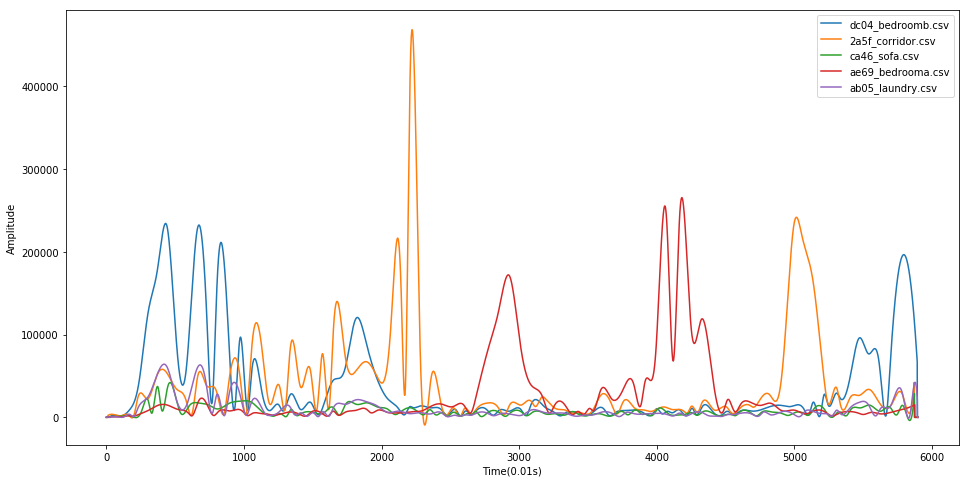

###################################################################################################################
16:23:30, 16:24:40, Shushan, Sheet1
nan detected!


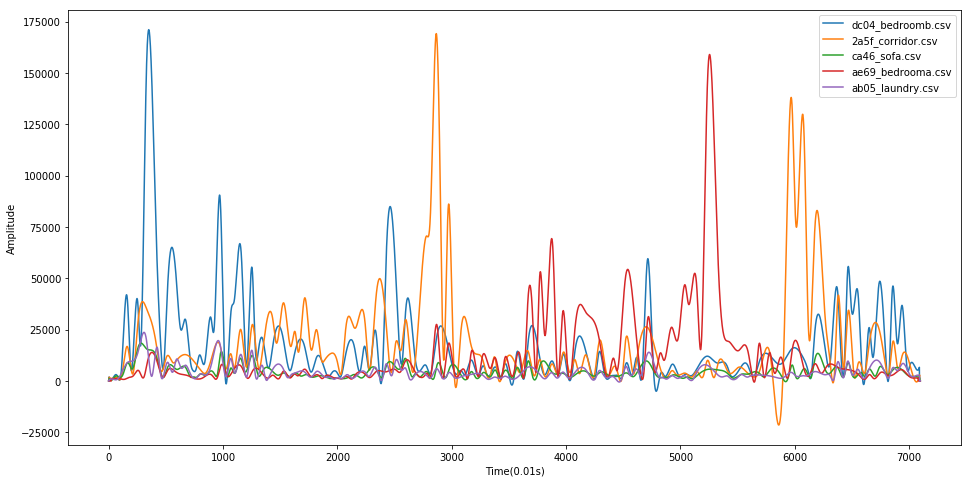

###################################################################################################################
16:26:00, 16:27:03, Huimin, Sheet1
nan detected!


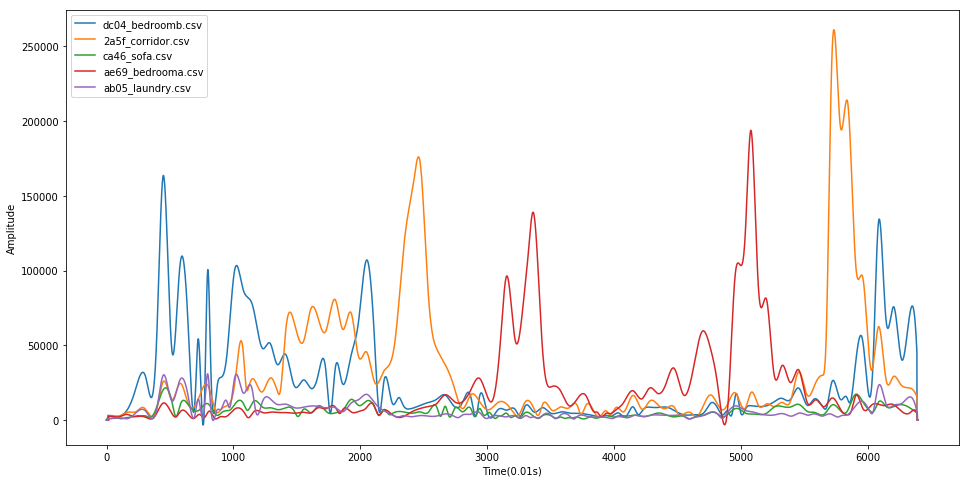

###################################################################################################################
16:28:00, 16:28:59, Zhen, Sheet1
nan detected!


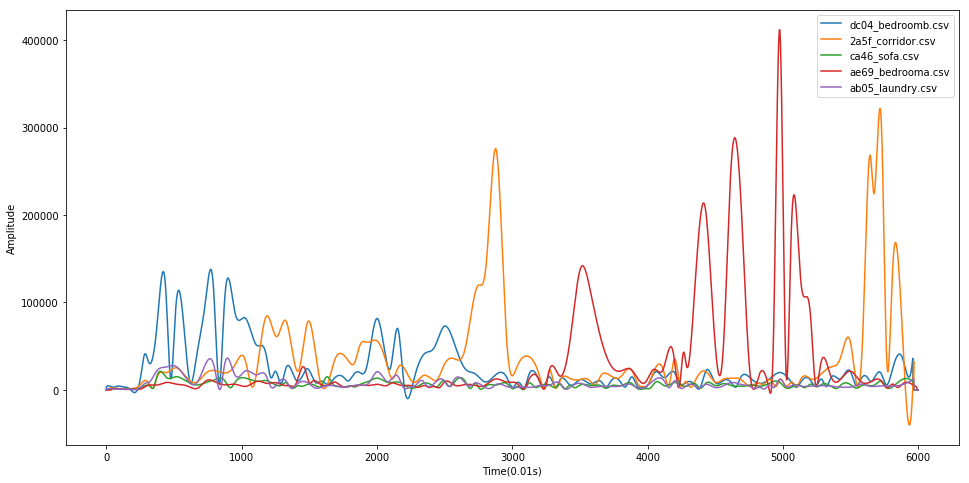

###################################################################################################################
16:31:00, 16:32:08, Hou, Sheet1
nan detected!


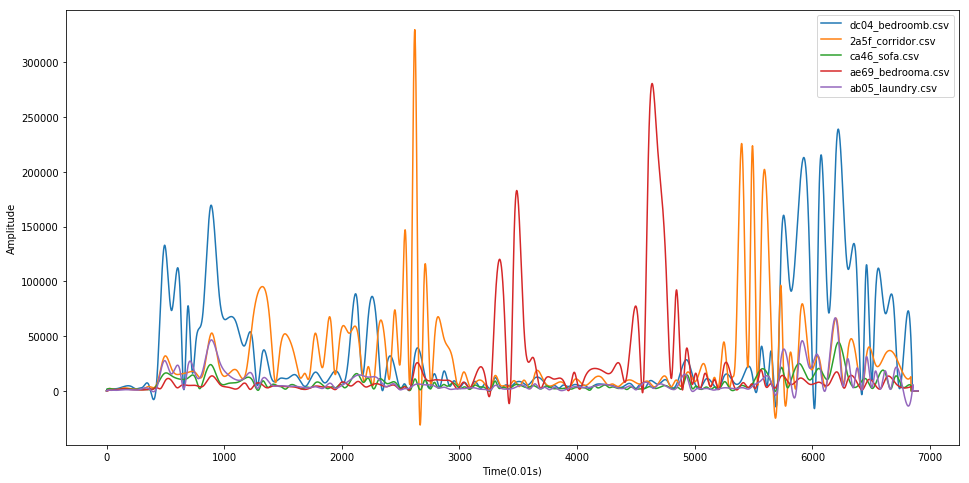

###################################################################################################################
16:33:00, 16:34:00, Kai, Sheet1
nan detected!


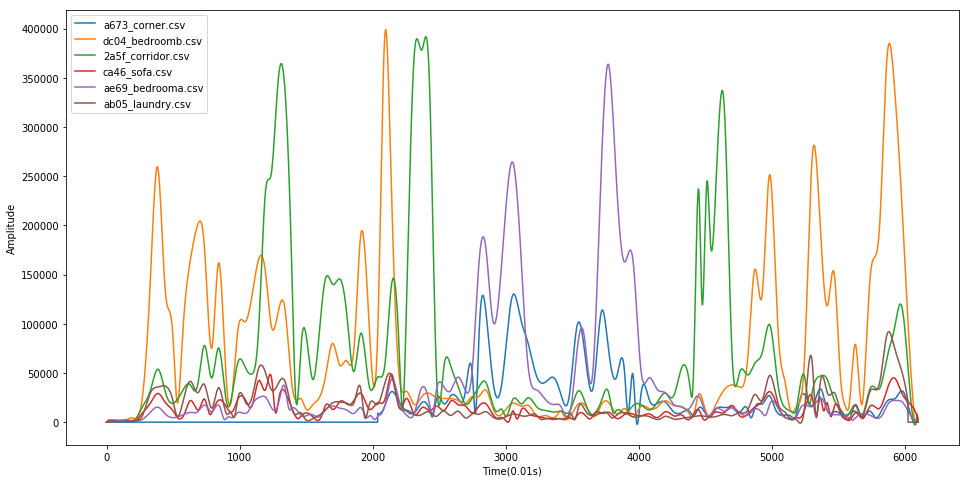

###################################################################################################################
16:35:00, 16:36:00, Sili, Sheet1
nan detected!


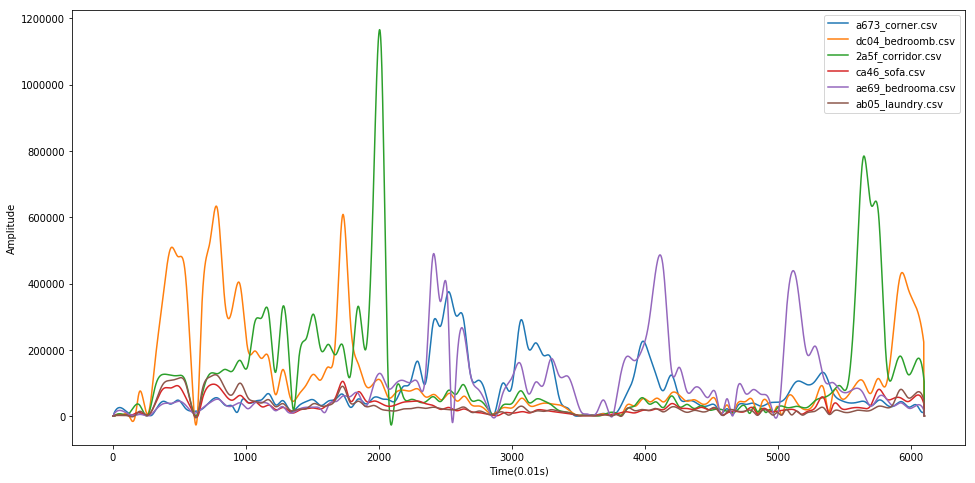

###################################################################################################################
16:39:20, 16:39:50, Huimin, Sheet2
nan detected!


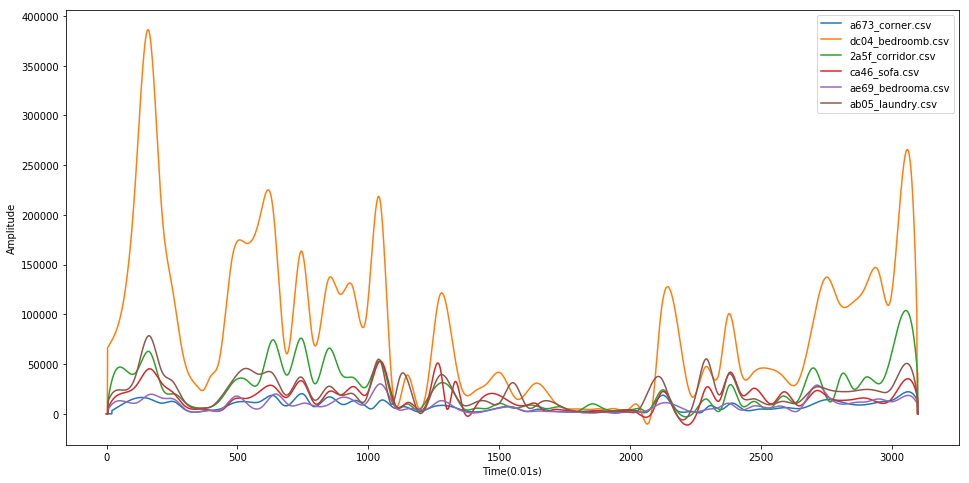

###################################################################################################################
16:40:47, 16:41:10, Zhen, Sheet2
nan detected!


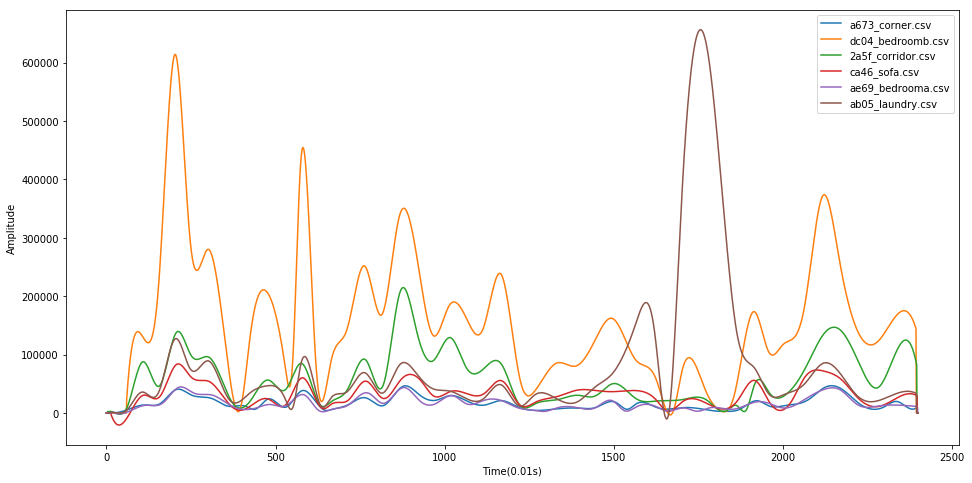

###################################################################################################################
16:42:57, 16:43:24, Hou, Sheet2
nan detected!


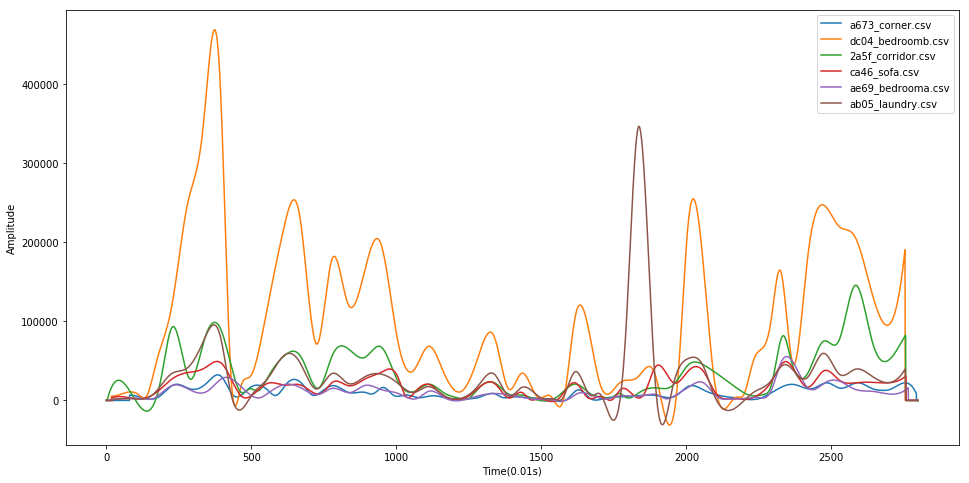

###################################################################################################################
16:43:37, 16:44:06, Kai, Sheet2
nan detected!


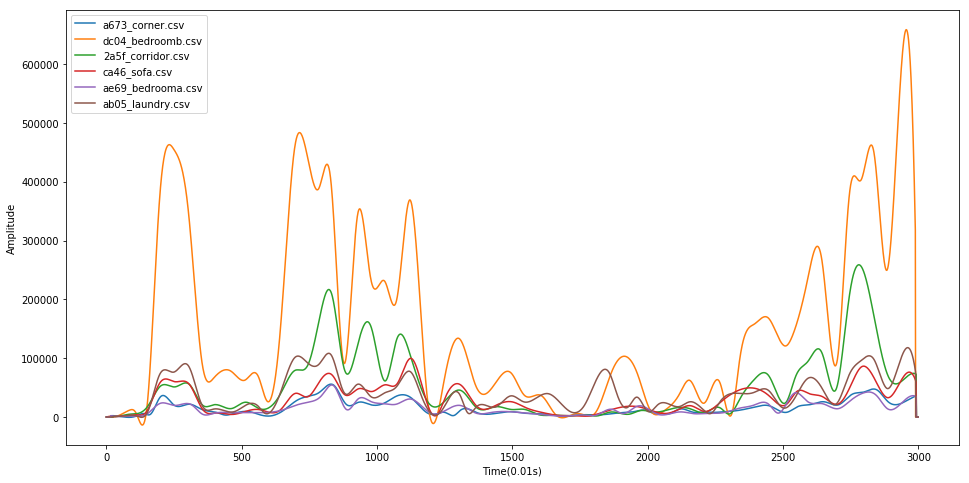

###################################################################################################################
16:44:28, 16:44:56, Sili, Sheet2
nan detected!


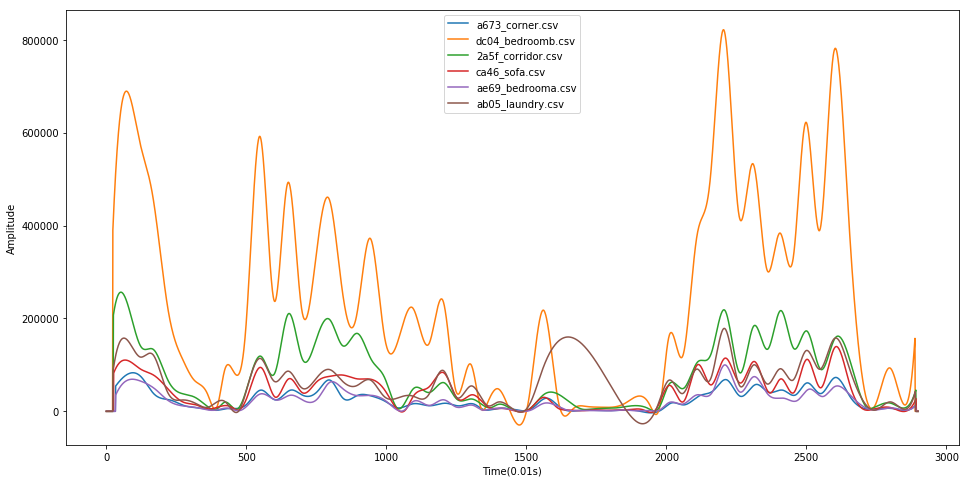

###################################################################################################################
16:45:15, 16:45:50, Shushan, Sheet2
nan detected!


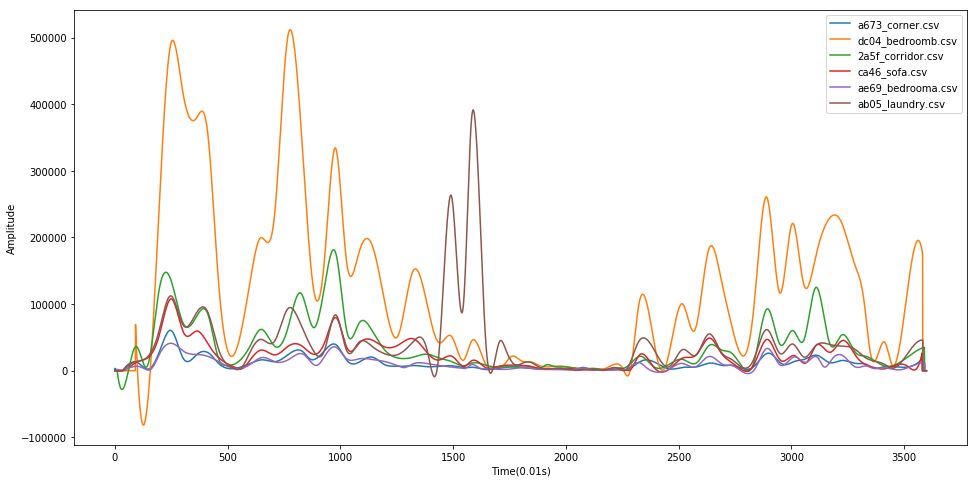

###################################################################################################################
16:48:21, 16:49:01, Yu, Sheet2
nan detected!


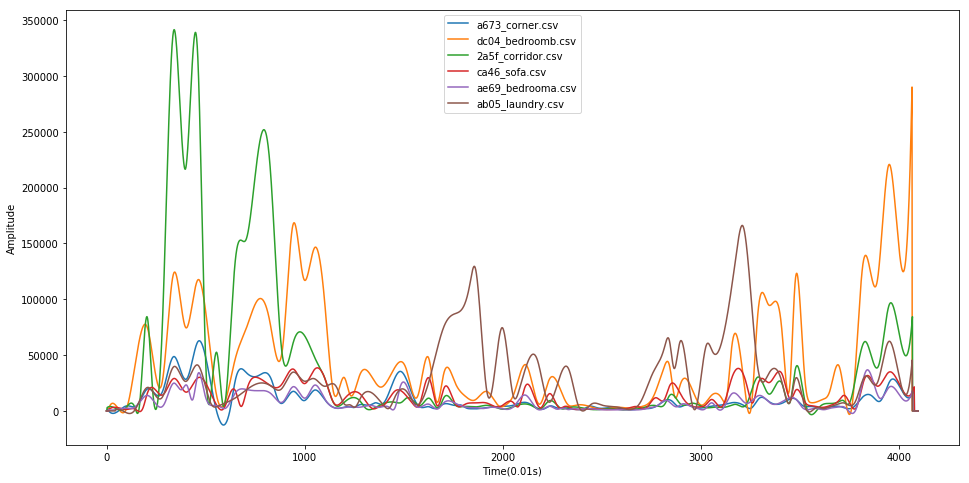

###################################################################################################################
16:50:18, 16:50:47, Hou, Sheet3
nan detected!


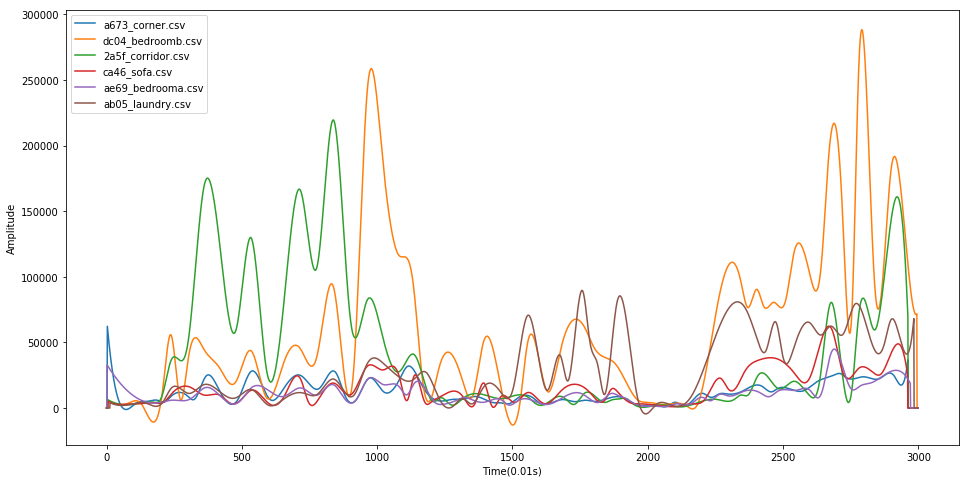

###################################################################################################################
16:52:50, 16:53:24, Zhen, Sheet3
nan detected!


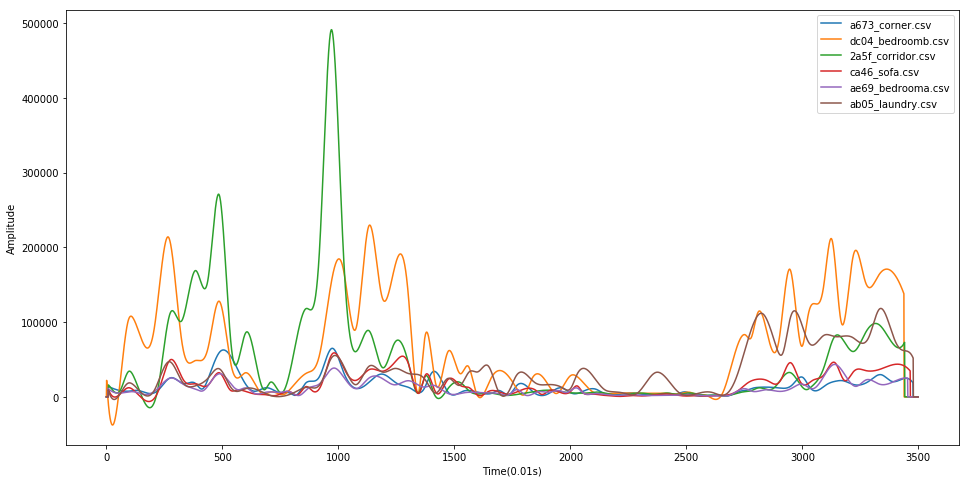

###################################################################################################################
16:54:28, 16:54:54, Yu, Sheet3
nan detected!


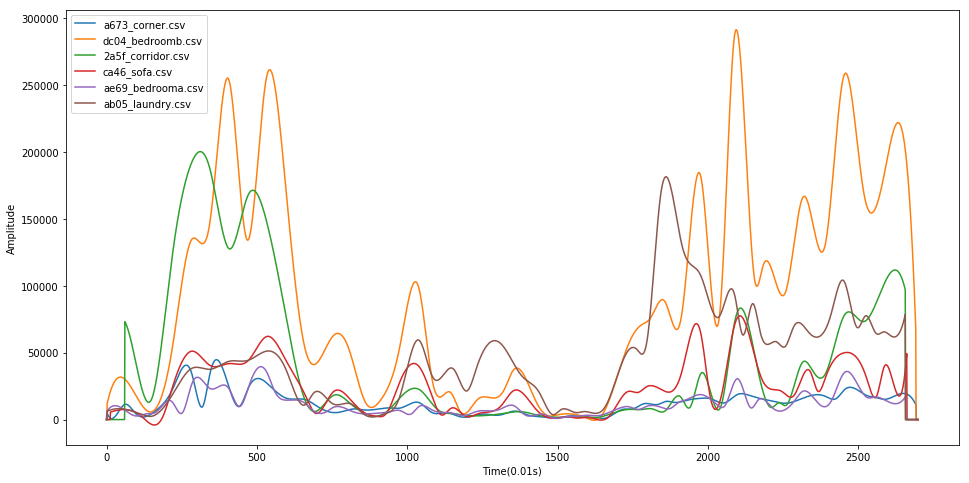

###################################################################################################################
17:12:15, 17:12:48, Huimin, Sheet4
nan detected!


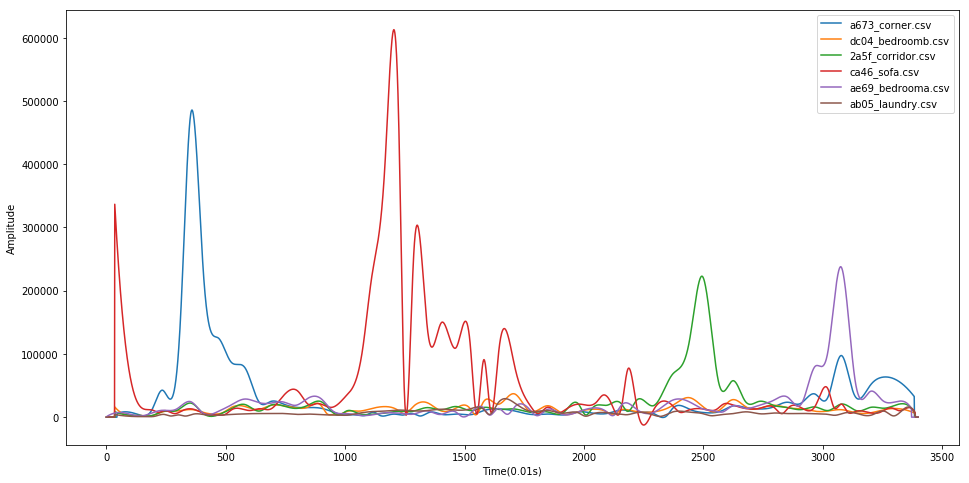

###################################################################################################################
17:14:16, 17:14:40, Zhen, Sheet4
nan detected!


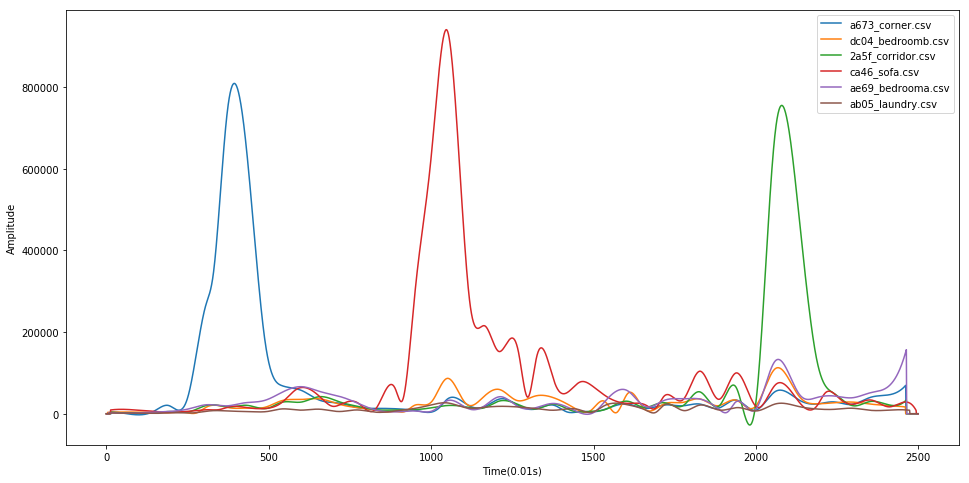

###################################################################################################################
17:15:31, 17:15:57, Hou, Sheet4
nan detected!


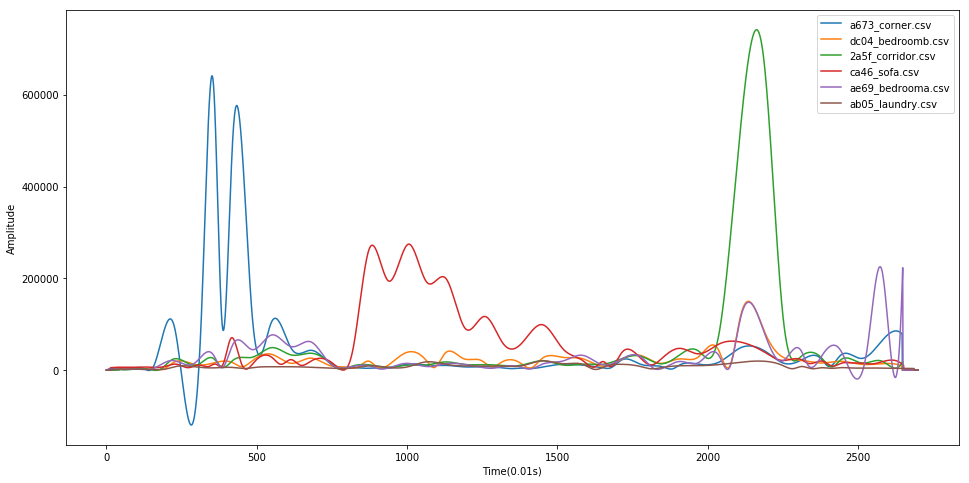

###################################################################################################################
17:16:32, 17:17:03, Shushan, Sheet4
nan detected!


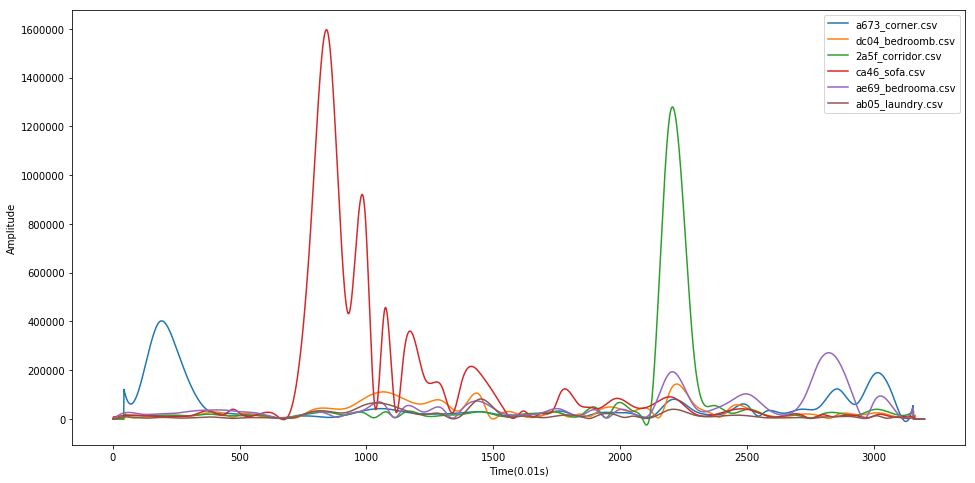

###################################################################################################################
17:17:48, 17:18:12, Sili, Sheet4
nan detected!


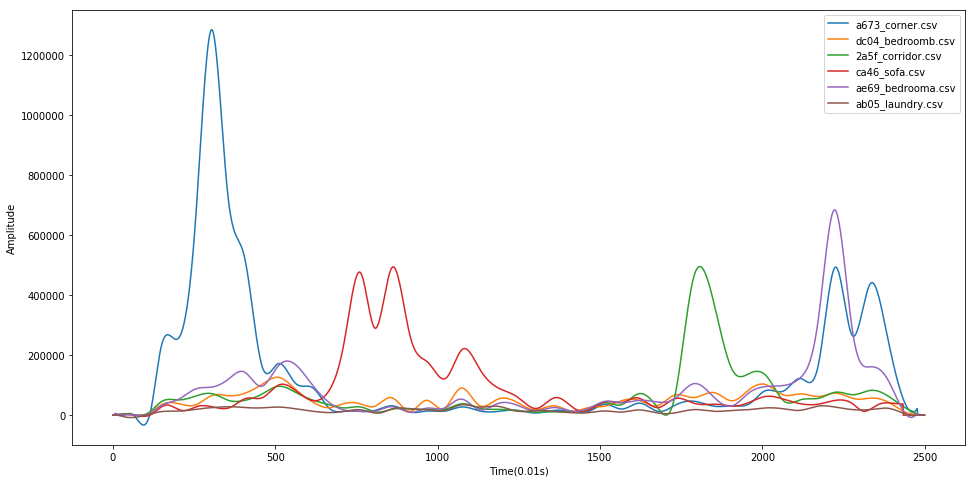

###################################################################################################################
17:19:10, 17:19:48, Yu, Sheet4
nan detected!


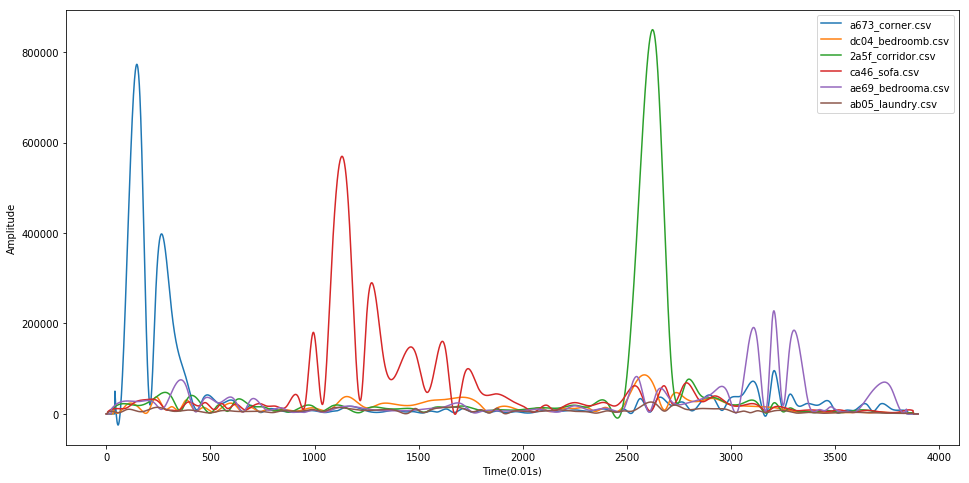

###################################################################################################################
17:20:30, 17:20:58, Kai, Sheet4
nan detected!


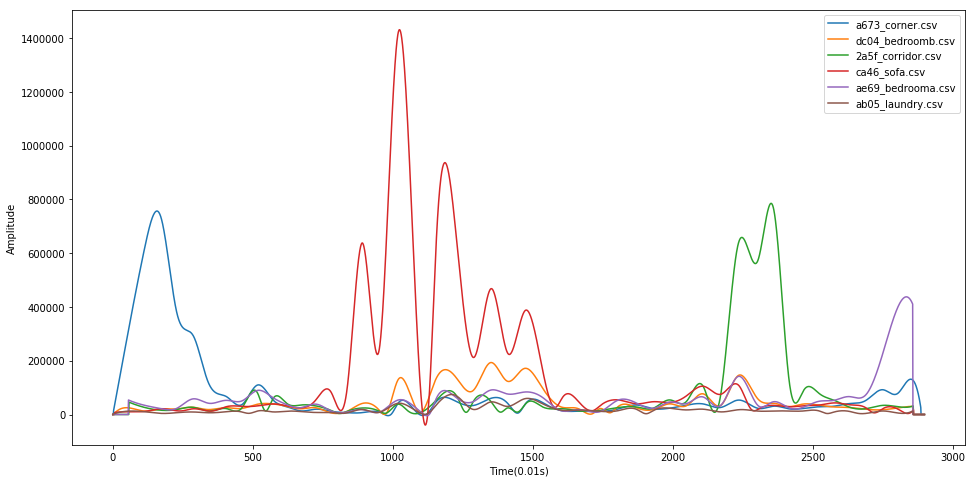

###################################################################################################################
17:30:50, 17:32:11, Yu, Sheet5
nan detected!


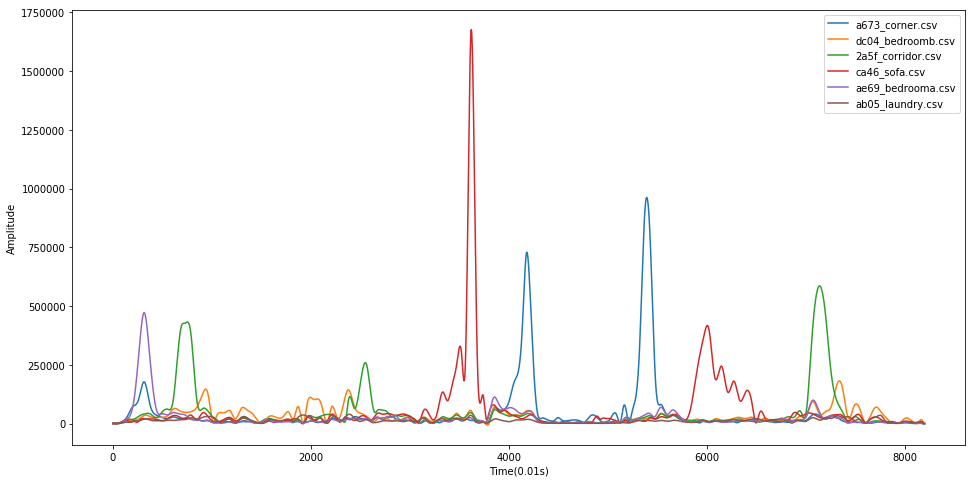

###################################################################################################################
17:33:30, 17:35:07, Zhen, Sheet5
nan detected!


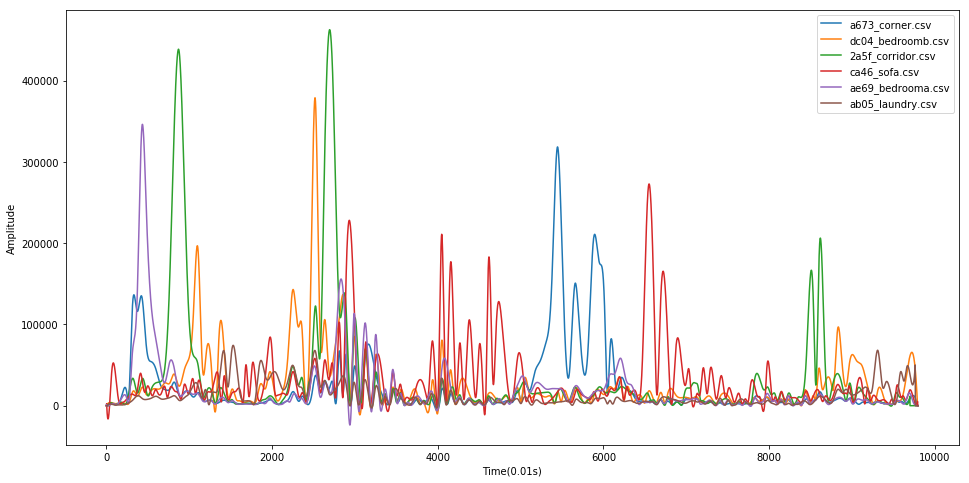

###################################################################################################################
17:36:07, 17:37:08, Kai, Sheet5
nan detected!


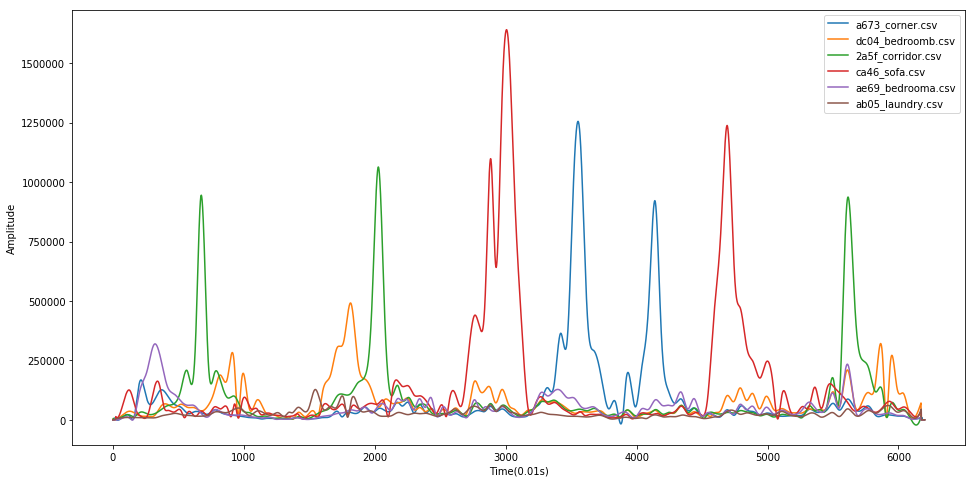

###################################################################################################################
17:38:16, 17:39:32, Shushan, Sheet5
nan detected!


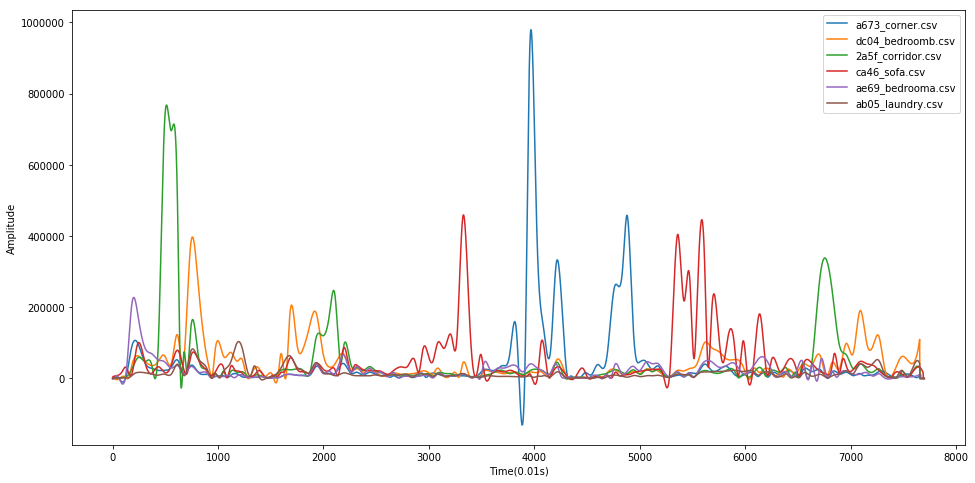

###################################################################################################################
17:40:22, 17:41:49, Hou, Sheet5
nan detected!


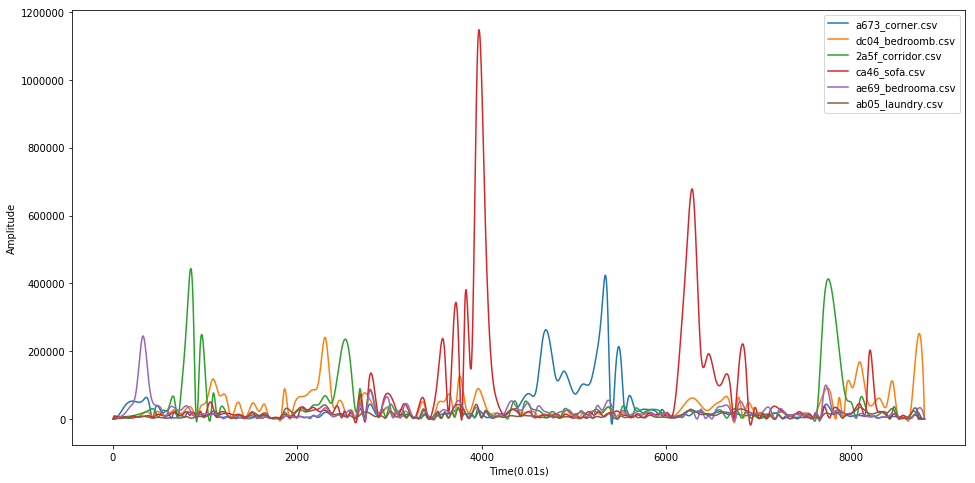

###################################################################################################################
17:42:20, 17:43:37, Sili, Sheet5
nan detected!


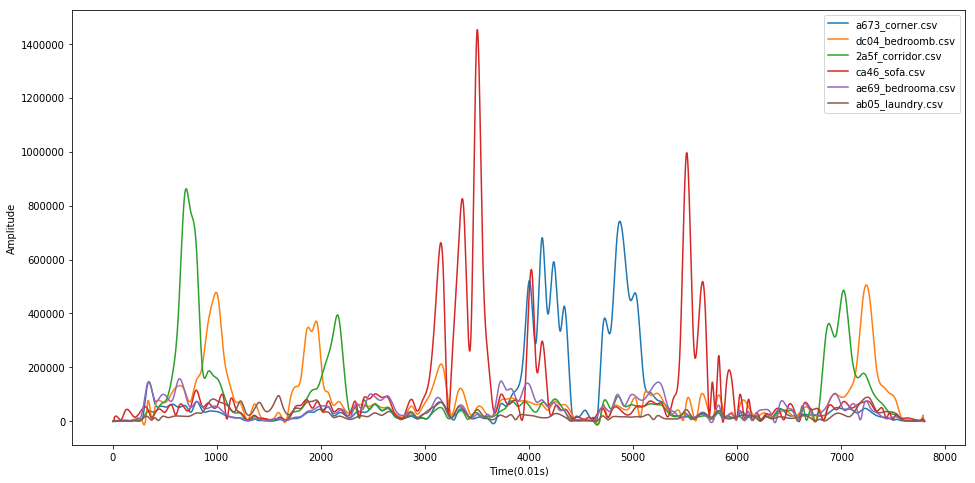

###################################################################################################################
17:44:40, 17:46:01, Huimin, Sheet5
nan detected!


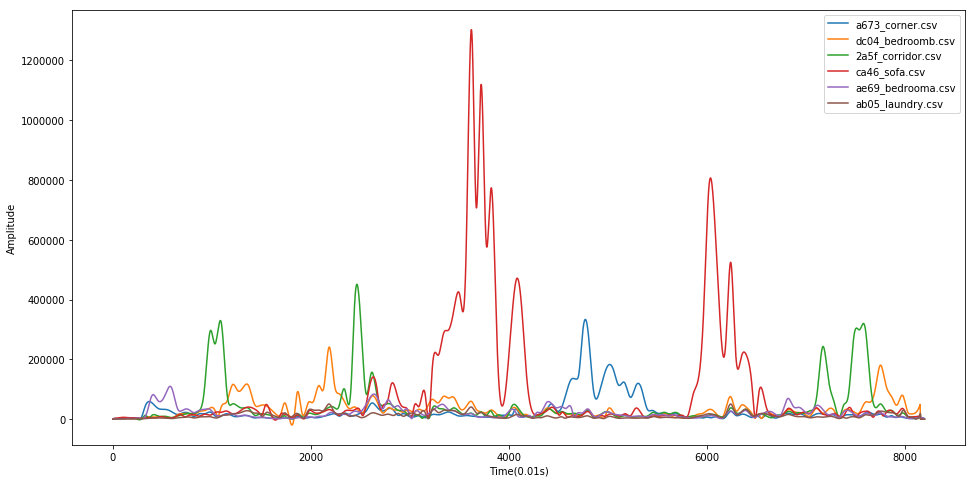

In [114]:
label_trajectory_filename = 'label_trajectory-time.xlsx'
sheetnames = ['Sheet1','Sheet2','Sheet3','Sheet4','Sheet5']
filenames = ['a673_corner.csv','dc04_bedroomb.csv','2a5f_corridor.csv',
             'ca46_sofa.csv','ae69_bedrooma.csv','ab05_laundry.csv']
trajectory = {'Yu': [None for _ in range(5)],
                 'Shushan': [None for _ in range(5)],
                 'Huimin': [None for _ in range(5)],
                 'Zhen': [None for _ in range(5)],
                 'Hou': [None for _ in range(5)],
                 'Kai': [None for _ in range(5)],
                 'Sili': [None for _ in range(5)]}

for i in range(len(sheetnames)):
    sheetname = sheetnames[i]
    df = pd.read_excel(label_trajectory_filename,sheet_name=sheetname)
    personnames = list(df.index)
    for personname in personnames:
        time = list(map(str,list(df.loc[personname,:])))
        time = [t for t in time if not t=='nan']
        start_time = time[0]
        end_time = time[-1]
        envelope_results = aggrenvelope(start_time,end_time,filenames,personname,sheetname)
        trajectory[personname][i] = envelope_results

In [115]:
with open('trajectory.pickle', 'wb') as handle:
    pk.dump(trajectory, handle, protocol=pk.HIGHEST_PROTOCOL)

In [116]:
#trajs
trajs = {'Yu': [None for _ in range(5)],
         'Shushan': [None for _ in range(5)],
         'Huimin': [None for _ in range(5)],
         'Zhen': [None for _ in range(5)],
         'Hou': [None for _ in range(5)],
         'Kai': [None for _ in range(5)],
         'Sili': [None for _ in range(5)]}
thrd = 200000

for personname in trajectory.keys():
    envelope_results_list = trajectory[personname]
    for k in range(len(envelope_results_list)):
        envelope_results = envelope_results_list[k]
        if type(envelope_results) == type(None):
            continue
        N, L = envelope_results.shape[0], envelope_results.shape[1]
        traj = np.zeros(L)
        for i in range(N):
            nodei = envelope_results[i,:]
            peaksi, _ = sg.find_peaks(nodei, height=0)
            for j in peaksi:
                if nodei[j] > thrd and N == 5:
                    traj[j] = (i+2)
                elif nodei[j] > thrd and N == 6:
                    traj[j] = (i+1)
        trajs[personname][k] = traj
        
#results
results = {'Yu': [None for _ in range(5)],
         'Shushan': [None for _ in range(5)],
         'Huimin': [None for _ in range(5)],
         'Zhen': [None for _ in range(5)],
         'Hou': [None for _ in range(5)],
         'Kai': [None for _ in range(5)],
         'Sili': [None for _ in range(5)]}
for personname in trajs.keys():
    traj_list = trajs[personname]
    for k in range(len(traj_list)):
        traj = traj_list[k]
        res = []
        if type(traj) == type(None):
            continue
        for t in traj:
            if t != 0:
                if not res or res[-1] != t:
                    res.append(t)
        results[personname][k] = res

In [119]:
# label - node
# 1.0 - a673_corner
# 2.0 - dc04_bedroomb
# 3.0 - 2a5f_corridor
# 4.0 - ca46_sofa
# 5.0 - ae69_bedrooma
# 6.0 - ab05_laundry
results

{'Yu': [[2.0, 3.0, 5.0, 3.0],
  [3.0, 2.0],
  [3.0, 2.0],
  [1.0, 4.0, 3.0, 5.0],
  [5.0, 3.0, 4.0, 1.0, 4.0, 3.0]],
 'Shushan': [[],
  [2.0, 6.0, 2.0],
  None,
  [1.0, 4.0, 3.0, 5.0],
  [5.0, 3.0, 2.0, 3.0, 4.0, 1.0, 4.0, 3.0]],
 'Huimin': [[3.0],
  [2.0],
  None,
  [4.0, 1.0, 4.0, 3.0, 5.0],
  [3.0, 2.0, 3.0, 4.0, 1.0, 4.0, 3.0]],
 'Zhen': [[3.0, 5.0, 3.0],
  [2.0, 3.0, 2.0, 6.0, 2.0],
  [2.0, 3.0, 2.0],
  [1.0, 4.0, 3.0],
  [5.0, 3.0, 2.0, 3.0, 4.0, 1.0, 4.0, 3.0]],
 'Hou': [[3.0, 5.0, 3.0, 2.0],
  [2.0, 6.0, 2.0],
  [3.0, 2.0],
  [1.0, 4.0, 3.0, 5.0],
  [5.0, 3.0, 2.0, 3.0, 4.0, 1.0, 4.0, 3.0, 4.0, 2.0]],
 'Kai': [[2.0, 3.0, 2.0, 3.0, 5.0, 3.0, 2.0],
  [2.0, 3.0, 2.0, 3.0, 2.0],
  None,
  [1.0, 4.0, 3.0, 5.0],
  [5.0, 3.0, 2.0, 3.0, 4.0, 1.0, 4.0, 5.0, 2.0, 3.0, 2.0]],
 'Sili': [[2.0, 3.0, 2.0, 3.0, 5.0, 1.0, 5.0, 1.0, 5.0, 1.0, 5.0, 3.0, 2.0],
  [3.0, 2.0, 3.0, 2.0, 3.0, 2.0, 3.0, 2.0],
  None,
  [1.0, 4.0, 3.0, 5.0, 1.0],
  [3.0, 2.0, 3.0, 4.0, 2.0, 4.0, 1.0, 4.0, 1.0, 4.0, 3.0, 

In [139]:
def seisTS(start_time,end_time,filenames):
    '''
    example:
    start_time = '16:39:20'
    end_time = '16:39:50'
    filenames = ['a673_corner.csv','dc04_bedroomb.csv','2a5f_corridor.csv',
                 'ca46_sofa.csv','ae69_bedrooma.csv','ab05_laundry.csv']
    '''
    
    print('#'*115)
    print('{}, {}'.format(start_time,end_time))
    
    start_timestamp = tm.mktime(dt.datetime.strptime(start_time, "%H:%M:%S").timetuple())
    end_timestamp = tm.mktime(dt.datetime.strptime(end_time, "%H:%M:%S").timetuple())
    
    timestamp_list = []
    
    for filename in filenames:
        with open(filename, newline='') as csvfile:
            spamreader = csv.reader(csvfile)
            timestamp = []
            first = True
            for row in spamreader:
                if first:
                    first = False
                    continue
                row = row[0].split(';')
                curr_time = row[1].strip('"').split('T')[1].split('-')[0]
                curr_timestamp = tm.mktime(dt.datetime.strptime(curr_time, "%H:%M:%S").timetuple())
                if curr_timestamp >= start_timestamp and curr_timestamp <= end_timestamp:
                    timestamp.append(curr_time)
            #timestamp = np.array(timestamp)  
        if not timestamp:
            continue
        timestamp_list.append(timestamp)
    
    return timestamp_list


In [140]:
#timestamp
label_trajectory_filename = 'label_trajectory-time.xlsx'
sheetnames = ['Sheet1','Sheet2','Sheet3','Sheet4','Sheet5']
filenames = ['a673_corner.csv','dc04_bedroomb.csv','2a5f_corridor.csv',
             'ca46_sofa.csv','ae69_bedrooma.csv','ab05_laundry.csv']
timestamps = {'Yu': [None for _ in range(5)],
                 'Shushan': [None for _ in range(5)],
                 'Huimin': [None for _ in range(5)],
                 'Zhen': [None for _ in range(5)],
                 'Hou': [None for _ in range(5)],
                 'Kai': [None for _ in range(5)],
                 'Sili': [None for _ in range(5)]}

for i in range(len(sheetnames)):
    sheetname = sheetnames[i]
    df = pd.read_excel(label_trajectory_filename,sheet_name=sheetname)
    personnames = list(df.index)
    for personname in personnames:
        time = list(map(str,list(df.loc[personname,:])))
        time = [t for t in time if not t=='nan']
        start_time = time[0]
        end_time = time[-1]
        timestamp_list = seisTS(start_time,end_time,filenames)
        timestamps[personname][i] = timestamp_list
        
timestamps

###################################################################################################################
16:21:00, 16:21:58
###################################################################################################################
16:23:30, 16:24:40
###################################################################################################################
16:26:00, 16:27:03
###################################################################################################################
16:28:00, 16:28:59
###################################################################################################################
16:31:00, 16:32:08
###################################################################################################################
16:33:00, 16:34:00
###################################################################################################################
16:35:00, 16:36:00
#######################################################

{'Yu': [[['16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
    '16:21:00',
  

In [ ]:
#trajs_timestamp
trajs_timestamp = {'Yu': [None for _ in range(5)],
         'Shushan': [None for _ in range(5)],
         'Huimin': [None for _ in range(5)],
         'Zhen': [None for _ in range(5)],
         'Hou': [None for _ in range(5)],
         'Kai': [None for _ in range(5)],
         'Sili': [None for _ in range(5)]}
thrd = 200000

for personname in trajectory.keys():
    envelope_results_list = trajectory[personname]
    timestamp_lists = timestamps[personname]
    for k in range(len(envelope_results_list)):
        envelope_results = envelope_results_list[k]
        if type(envelope_results) == type(None):
            continue
        timestamp_list = timestamp_lists[k][1]
        N, L = envelope_results.shape[0], envelope_results.shape[1]
        traj = []
        for i in range(L):
            traj.append([0,timestamp_list[i]])
        for i in range(N):
            nodei = envelope_results[i,:]
            peaksi, _ = sg.find_peaks(nodei, height=0)
            for j in peaksi:
                if nodei[j] > thrd and N == 5:
                    traj[j][0] = (i+2)
                elif nodei[j] > thrd and N == 6:
                    traj[j][0] = (i+1)
        trajs_timestamp[personname][k] = traj
        
#results_timestamp
results_timestamp = {'Yu': [None for _ in range(5)],
         'Shushan': [None for _ in range(5)],
         'Huimin': [None for _ in range(5)],
         'Zhen': [None for _ in range(5)],
         'Hou': [None for _ in range(5)],
         'Kai': [None for _ in range(5)],
         'Sili': [None for _ in range(5)]}

for personname in trajs_timestamp.keys():
    traj_timestamp_list = trajs_timestamp[personname]
    for k in range(len(traj_timestamp_list)):
        traj = traj_timestamp_list[k]
        res = []
        if type(traj) == type(None):
            continue
        for pos, ts in traj:
            if pos != 0:
                if not res or res[-1][0] != pos:
                    res.append([pos, ts])
        results_timestamp[personname][k] = res

In [165]:
# label - node
# 1.0 - a673_corner
# 2.0 - dc04_bedroomb
# 3.0 - 2a5f_corridor
# 4.0 - ca46_sofa
# 5.0 - ae69_bedrooma
# 6.0 - ab05_laundry
results_timestamp

{'Yu': [[[2, '16:21:04'], [3, '16:21:21'], [5, '16:21:40'], [3, '16:21:50']],
  [[3, '16:48:24'], [2, '16:49:00']],
  [[3, '16:54:31'], [2, '16:54:32']],
  [[1, '17:19:11'], [4, '17:19:21'], [3, '17:19:36'], [5, '17:19:42']],
  [[5, '17:30:53'],
   [3, '17:30:57'],
   [4, '17:31:25'],
   [1, '17:31:31'],
   [4, '17:31:50'],
   [3, '17:32:01']]],
 'Shushan': [[],
  [[2, '16:45:17'], [6, '16:45:29'], [2, '16:45:43']],
  None,
  [[1, '17:16:33'], [4, '17:16:40'], [3, '17:16:54'], [5, '17:17:00']],
  [[5, '17:38:18'],
   [3, '17:38:21'],
   [2, '17:38:23'],
   [3, '17:38:36'],
   [4, '17:38:49'],
   [1, '17:38:55'],
   [4, '17:39:09'],
   [3, '17:39:23']]],
 'Huimin': [[[3, '16:26:57']],
  [[2, '16:39:21']],
  None,
  [[4, '17:12:15'],
   [1, '17:12:18'],
   [4, '17:12:27'],
   [3, '17:12:39'],
   [5, '17:12:45']],
  [[3, '17:44:49'],
   [2, '17:45:01'],
   [3, '17:45:04'],
   [4, '17:45:12'],
   [1, '17:45:27'],
   [4, '17:45:40'],
   [3, '17:45:51']]],
 'Zhen': [[[3, '16:28:28'], [5, '16